# 1. Predictive Model Selection for Seasonal Stream Forecasting

---------

- **Data Structure**: Panel data of 7 Christmas songs, with weekly streams from 2017 to 2025, concentrated in the high-season (weeks 45-52).
- **Modeling Approach**: The core methodology transforms the data into multiple, independent time series. For each song, a separate time series is created for each week of the Christmas season (e.g., one series for Week 45 streams across all years, another for Week 46, etc.).
- **Time Series Characteristics**: Each resulting time series is short, containing approximately 8 data points (one for each year from 2017-2024), representing the year-over-year performance for a specific week. This isolates the annual trend and simplifies the forecasting challenge by removing complex seasonality.


| **Criterion**         | **Moving Average**                      | **ARIMA (Chosen)**                                    | **LSTM**                                       | **Prophet**                                         |
|-----------------------|-----------------------------------------|-------------------------------------------------------|------------------------------------------------|-----------------------------------------------------|
| **Complexity**        | Very Low                                | Low - Simple ARIMA(1,1,1) used                        | Very High - Neural network architecture        | Medium - Automated but complex for this use case    |
| **Data Requirements** | Minimal                                 | **Ideal for short series (8 data points/year)**       | Very Large - Requires thousands of data points | Moderate - Best with longer, more granular data     |
| **Seasonality**       | None                                    | Not needed; seasonality is handled by the data split  | Learns patterns but needs huge data            | Overkill; designed for multi-level seasonality      |
| **Interpretability**  | High                                    | High - Clear statistical parameters (p,d,q)           | Very Low - Black-box model                     | Medium - Decomposes trend/seasonality               |
| **Training Time**     | Instant                                 | Very Fast - Milliseconds per model                    | Slow - Minutes to hours                        | Fast                                                |
| **Overfitting Risk**  | None                                    | Low - Few parameters, simple model                    | **Extremely High** - Unusable on 8 data points | High - Would overfit on such a short series         |
| **Trend Capture**     | Poor - Only smooths                     | Excellent - Differencing (d=1) captures year-over-year trend | Can learn trends, but not with 8 data points   | Good, but not optimized for this data structure     |
| **Suitability**       | **Poor** - Only a baseline              | **Excellent** - Optimal balance for this methodology  | **Unsuitable** - Requires vastly more data     | **Poor** - Wrong tool for short, annual series      |




The selected modeling approach—building an independent **ARIMA(1,1,1) model for each week of the Christmas season per song**—is uniquely suited to the dataset's structure. This method effectively transforms the problem into a series of simple, univariate forecasts on short time series (approx. 8 annual data points each), making complex models not only unnecessary but inappropriate.

- **ARIMA** was chosen because it is statistically robust and highly effective for short series where the primary goal is to model year-over-year trends and autocorrelation. Its simplicity, low computational cost, and high interpretability make it the perfect fit.

- **LSTM** networks were discarded due to the extremely small size of each individual time series. Attempting to train a deep learning model on only 8 data points would result in immediate, severe overfitting, producing meaningless forecasts.

- **Prophet**, while powerful for time series with daily or weekly granularity and multiple seasonalities, is not designed for this specific setup. Its features for modeling holiday effects and complex cycles are overkill and would likely fail to produce reliable results on a short series of annual data points.

I transformed the complex forecasting problem by decomposing each song's data into independent, annual mini-series for each week of the Christmas season (Weeks 45-52+1). This created simple 8-point time series capturing year-over-year trends for specific weekly snapshots. An ARIMA(1,1,1) model was then fitted to each series, providing a statistically robust approach suitable for such short sequences. This method intentionally sacrifices intra-seasonal pattern recognition to focus exclusively on annual trend forecasting with minimal complexity.

# 2. The ARIMA Model: Theoretical Foundation

------------



The **ARIMA(p,d,q)** model combines three components to forecast time series:

**AR(p) - Autoregressive**: Uses *past values* as predictors  
`y_t = c + φ₁y_{t-1} + ... + φ_py_{t-p} + ε_t`

**I(d) - Integration**: Differences the series *d times* to achieve stationarity  
`Δy_t = y_t - y_{t-1}`

**MA(q) - Moving Average**: Uses *past forecast errors* as predictors  
`y_t = c + ε_t + θ₁ε_{t-1} + ... + θ_qε_{t-q}`

### General Linear Equation: ARIMA(p,d,q)

$$Y_t = c + \underbrace{\phi_1 Y_{t-1} + \dots + \phi_p Y_{t-p}}_{\text{AR: Past Values}} + \underbrace{\theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}}_{\text{MA: Past Errors}} + \varepsilon_t$$

#### Legend and Concepts:

* **$Y_t$ — Where is the "I" (Integration)?**
  This $Y_t$ is **not** the raw data, but the series **after differentiation** $d$ times (made stationary).
  * The **"I"** is the pre-processing step: $Y_t = \text{Data}_t - \text{Data}_{t-1}$.
  * The model attempts to forecast this *difference* (change), not the absolute value directly.

* **$\phi_p \times Y_{t-p}$ — The "AR" Term (Autoregressive):**
  Regression based on the series' own past values.
  * **Concept:** "If the value (or change) was high yesterday, it will likely be high today (inertia/momentum)."
  * $\phi$: Represents the weight/importance of the past.

* **$\theta_q \times \varepsilon_{t-q}$ — The "MA" Term (Moving Average):**
  Regression based on past forecast errors.
  * **Concept:** "If I made a large error in yesterday's forecast (an unexpected shock), I will use that error to adjust today's forecast."
  * $\varepsilon_{t-q}$: The residual (error) that occurred in the past.

* **$c$ and $\varepsilon_t$:**
  * $c$: A constant (intercept or drift).
  * $\varepsilon_t$: The current white noise (the new random error happening today that cannot be predicted).

In [18]:
import pandas as pd

# Note o 'r' antes das aspas
caminho_csv = "../data/raw/spotify_christmas_streams_kworb_2017_2025.csv."
df = pd.read_csv(caminho_csv)

print("✓ Dados carregados com sucesso!")
print(f"Shape: {df.shape}")
df.head()

✓ Dados carregados com sucesso!
Shape: (376, 6)


,date,track,artist,streams,day_of_week,week_of_year
0,2017-11-16,All I Want for Christmas Is You,Mariah Carey,3821572,Thursday,46
1,2017-11-23,All I Want for Christmas Is You,Mariah Carey,6130250,Thursday,47
2,2017-11-23,Last Christmas,Wham!,4040197,Thursday,47
3,2017-11-30,All I Want for Christmas Is You,Mariah Carey,11641888,Thursday,48
4,2017-11-30,It's Beginning to Look a Lot Like Christmas,Michael Bublé,4577042,Thursday,48


In [9]:
# Preparar dados
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['week_of_year'] = df['date'].dt.isocalendar().week

# Filtrar semanas 45-52 (Nov-Dez)
df_christmas = df[df['week_of_year'].between(45, 52)].copy()

# Lista de músicas (ajuste conforme seus dados)
songs = df_christmas['track'].unique()[:9]  # Top 9 músicas
print(f"Analisando {len(songs)} músicas")

# Criar matrizes por música (ano x semana)
matrices_per_song = {}

for song in songs:
    song_data = df_christmas[df_christmas['track'] == song]
    matrix = song_data.pivot_table(
        index='year',
        columns='week_of_year',
        values='streams',
        aggfunc='sum'
    )
    matrices_per_song[song] = matrix

# Separar dados de 2025 (se existirem)
actual_2025 = df_christmas[df_christmas['year'] == 2025].copy()

print("✓ Matrizes criadas com sucesso!")
print(f"Anos disponíveis: {sorted(df_christmas['year'].unique())}")

Analisando 7 músicas
✓ Matrizes criadas com sucesso!
Anos disponíveis: [np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]


In [10]:
# ========================================
# TREINO DOS MODELOS ARIMA
# ========================================

models_per_song = {}
validation_2024 = {}
forecasts_2025 = {}

print("=" * 80)
print("ARIMA FORECASTING - Christmas Songs 2025")
print("=" * 80)
print("\nTreinando modelos ARIMA(1,1,1) por semana por música...")

for song in songs:
    matrix = matrices_per_song[song]
    song_models = {}
    validation_results = {}
    forecast_values = {}

    for week in range(45, 53):
        if week in matrix.columns:
            week_series = matrix[week].dropna()

            if len(week_series) >= 5:
                # Treinar com dados até 2023
                train_series = week_series[week_series.index <= 2023]

                try:
                    # Treinar modelo ARIMA
                    model = ARIMA(train_series.values, order=(1, 1, 1))
                    fitted_model = model.fit()
                    song_models[week] = fitted_model

                    # Validação com 2024 (se disponível)
                    if 2024 in week_series.index:
                        pred_2024 = fitted_model.forecast(steps=1)[0]
                        actual_2024 = week_series[2024]
                        error_pct = abs(pred_2024 - actual_2024) / actual_2024 * 100
                        validation_results[week] = {
                            'predicted': pred_2024,
                            'actual': actual_2024,
                            'error_pct': error_pct
                        }

                    # Previsão para 2025 (2 passos à frente)
                    forecast_2steps = fitted_model.forecast(steps=2)
                    pred_2025 = forecast_2steps[1]
                    forecast_values[week] = pred_2025

                except Exception as e:
                    print(f"  Erro em {song} semana {week}: {e}")
                    continue

    # Salvar resultados
    if song_models:
        models_per_song[song] = song_models
    if validation_results:
        validation_2024[song] = validation_results
    if forecast_values:
        forecasts_2025[song] = pd.Series(forecast_values)

print(f"\n✓ Modelos treinados para {len(models_per_song)} músicas")
print(f"✓ Previsões 2025 geradas para {len(forecasts_2025)} músicas")

# ========================================
# RESUMO DE VALIDAÇÃO (2024)
# ========================================
print("\n" + "=" * 80)
print("RESUMO DE VALIDAÇÃO - 2024")
print("=" * 80)

for song in songs:
    if song in validation_2024 and validation_2024[song]:
        errors = [v['error_pct'] for v in validation_2024[song].values()]
        mape = np.mean(errors)
        print(f"{song[:40]:40s} | MAPE = {mape:6.1f}%")

print("=" * 80)

ARIMA FORECASTING - Christmas Songs 2025

Treinando modelos ARIMA(1,1,1) por semana por música...

✓ Modelos treinados para 7 músicas
✓ Previsões 2025 geradas para 7 músicas

RESUMO DE VALIDAÇÃO - 2024
All I Want for Christmas Is You          | MAPE =   15.5%
Last Christmas                           | MAPE =   18.7%
It's Beginning to Look a Lot Like Christ | MAPE =   21.6%
Rockin' Around the Christmas Tree        | MAPE =   19.4%
Santa Tell Me                            | MAPE =    8.8%
Feliz Navidad                            | MAPE =   12.0%
Jingle Bell Rock                         | MAPE =   15.7%


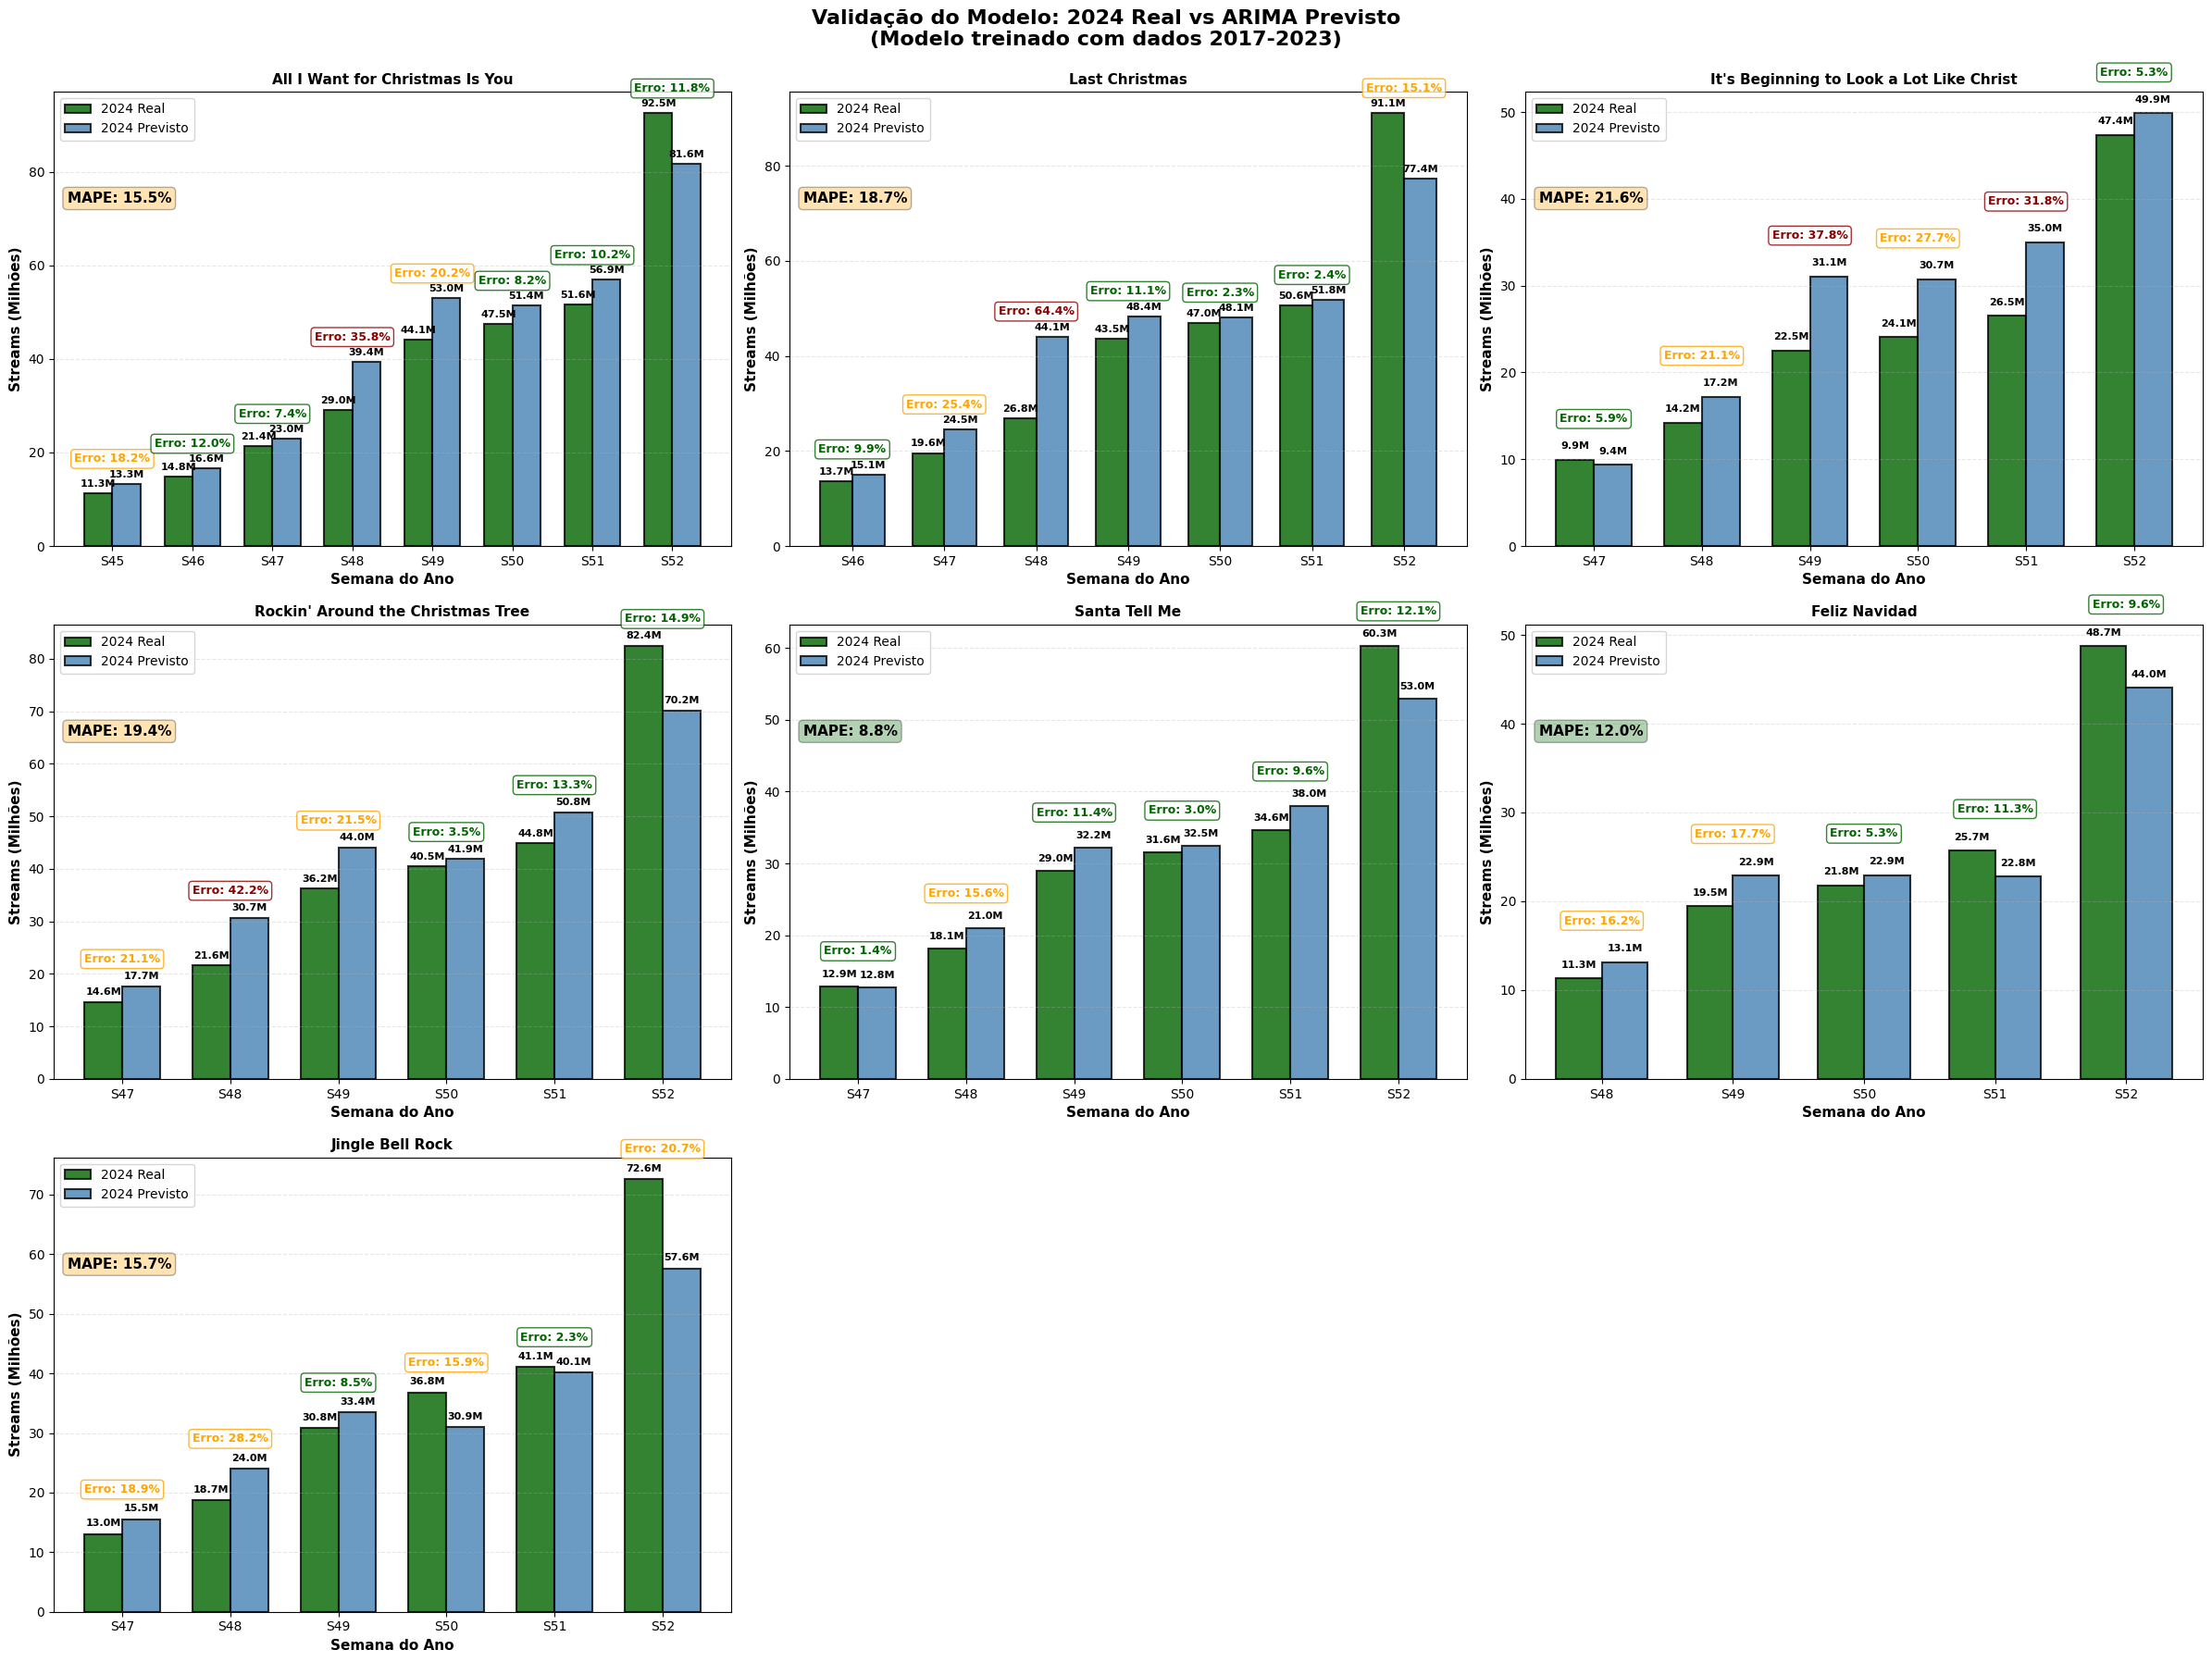


✓ Gráfico de validação gerado!


In [11]:
# ========================================
# GRÁFICO: VALIDAÇÃO 2024 (Actual vs Predicted)
# ========================================

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

for idx, song in enumerate(songs):
    if song not in validation_2024 or not validation_2024[song]:
        axes[idx].text(0.5, 0.5, f'{song}\nSem dados de validação', 
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue
    
    validation = validation_2024[song]
    weeks = sorted(validation.keys())
    
    actual_values = [validation[w]['actual'] / 1e6 for w in weeks]
    predicted_values = [validation[w]['predicted'] / 1e6 for w in weeks]
    errors = [validation[w]['error_pct'] for w in weeks]
    
    # Gráfico de barras
    x = np.arange(len(weeks))
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, actual_values, width, 
                          label='2024 Real', color='darkgreen', alpha=0.8, 
                          edgecolor='black', linewidth=1.5)
    bars2 = axes[idx].bar(x + width/2, predicted_values, width, 
                          label='2024 Previsto', color='steelblue', alpha=0.8, 
                          edgecolor='black', linewidth=1.5)
    
    # Adicionar valores nas barras
    for i, (actual, pred) in enumerate(zip(actual_values, predicted_values)):
        axes[idx].text(i - width/2, actual + 1, f'{actual:.1f}M', 
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
        axes[idx].text(i + width/2, pred + 1, f'{pred:.1f}M',
                      ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Adicionar % de erro
    for i, error in enumerate(errors):
        max_val = max(actual_values[i], predicted_values[i])
        error_color = 'darkgreen' if error < 15 else 'orange' if error < 30 else 'darkred'
        axes[idx].text(i, max_val + 4, f'Erro: {error:.1f}%',
                      ha='center', va='bottom', fontsize=9, fontweight='bold',
                      color=error_color,
                      bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                               edgecolor=error_color, alpha=0.8))
    
    # Formatação
    axes[idx].set_xlabel('Semana do Ano', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Streams (Milhões)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'S{w}' for w in weeks], fontsize=10)
    axes[idx].legend(fontsize=10, loc='upper left')
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')
    
    # MAPE
    mape = np.mean(errors)
    mape_color = 'darkgreen' if mape < 15 else 'orange' if mape < 30 else 'darkred'
    axes[idx].text(0.02, 0.78, f'MAPE: {mape:.1f}%',
                  transform=axes[idx].transAxes, fontsize=11, fontweight='bold',
                  verticalalignment='top', horizontalalignment='left',
                  bbox=dict(boxstyle='round', facecolor=mape_color, 
                           edgecolor='black', alpha=0.3))

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Validação do Modelo: 2024 Real vs ARIMA Previsto\n(Modelo treinado com dados 2017-2023)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Gráfico de validação gerado!")

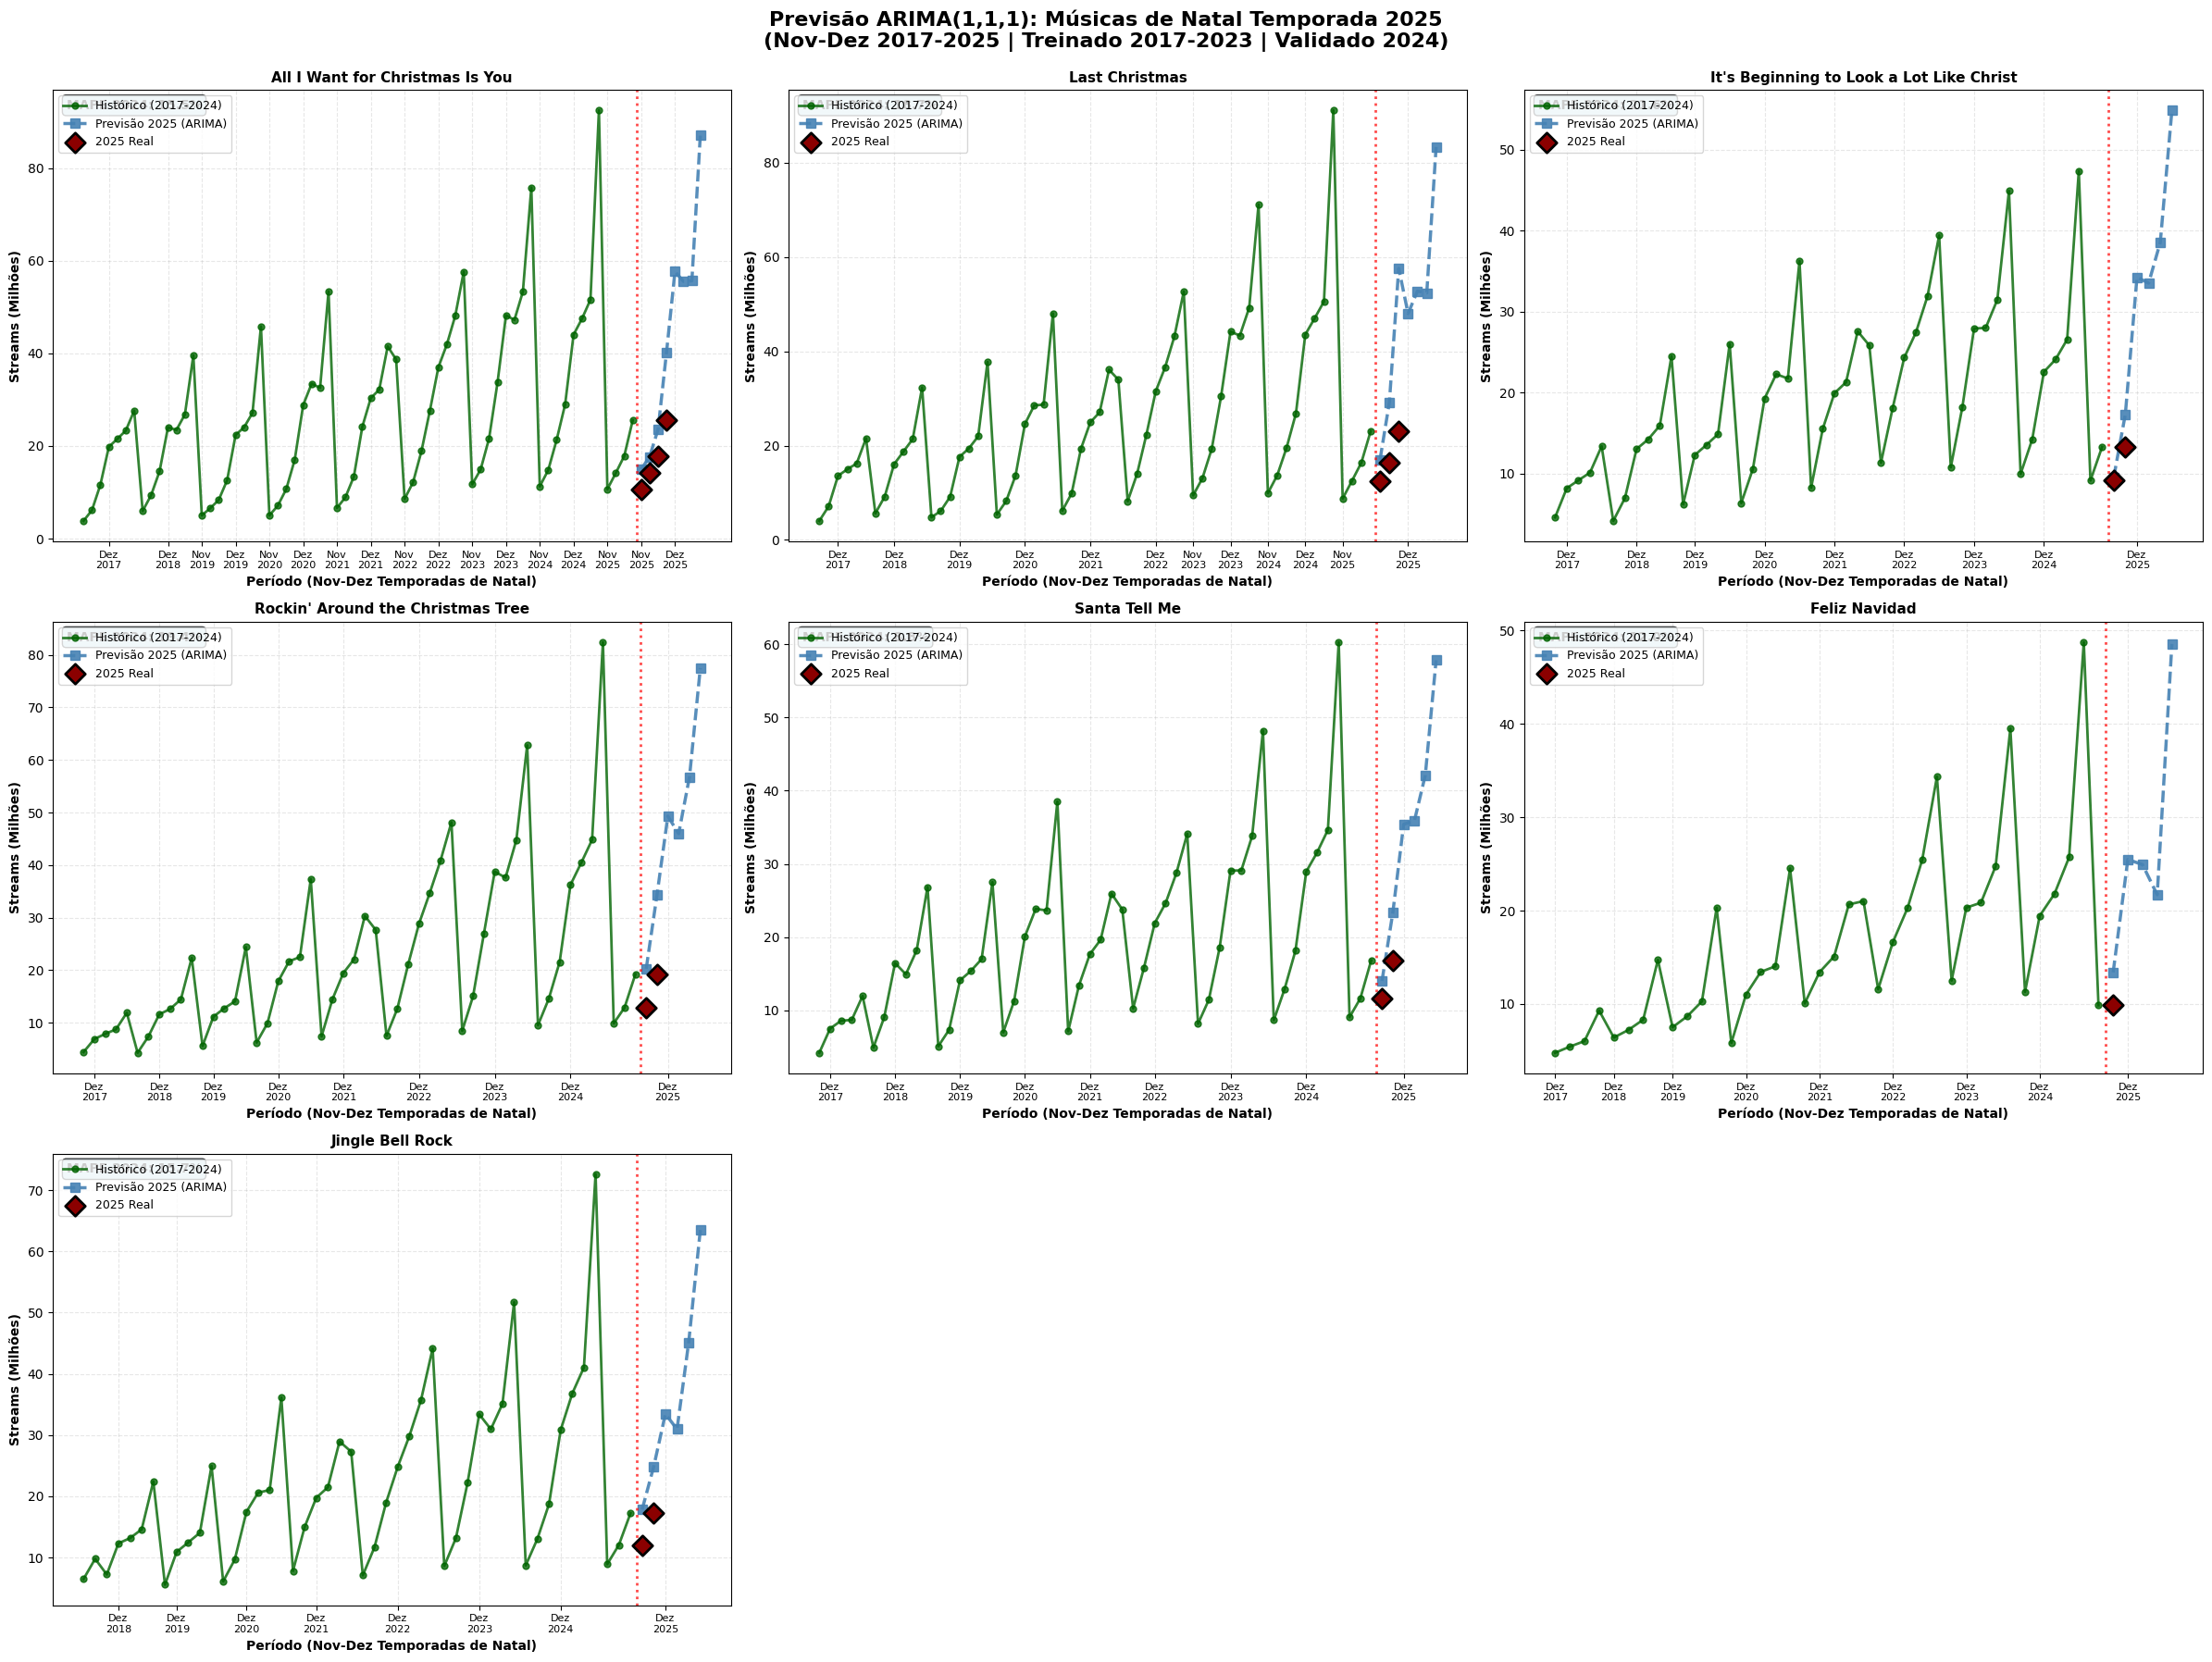


✓ Gráfico de série temporal completo gerado!


In [12]:
# ========================================
# GRÁFICO: SÉRIE TEMPORAL COMPLETA (2017-2025)
# ========================================

fig, axes = plt.subplots(3, 3, figsize=(24, 18))
axes = axes.flatten()

for idx, song in enumerate(songs):
    if song not in models_per_song or song not in forecasts_2025:
        axes[idx].text(0.5, 0.5, f'{song}\nSem previsão', 
                      ha='center', va='center', fontsize=10)
        axes[idx].axis('off')
        continue

    matrix = matrices_per_song[song]
    forecast_2025 = forecasts_2025[song]
    validation = validation_2024.get(song, {})
    actual_2025_song = actual_2025[actual_2025['track'] == song].groupby('week_of_year')['streams'].sum()

    # Criar série temporal contínua
    time_series_data = []
    month_markers = []
    month_labels = []
    position = 0

    # Dados históricos (2017-2024)
    for year in sorted(matrix.index):
        for week in range(45, 53):
            if week in matrix.columns and not pd.isna(matrix.loc[year, week]):
                time_series_data.append(matrix.loc[year, week] / 1e6)
                if week == 45:
                    month_markers.append(position)
                    month_labels.append(f'Nov\n{year}')
                elif week == 49:
                    month_markers.append(position)
                    month_labels.append(f'Dez\n{year}')
                position += 1

    # Previsão 2025
    forecast_data = []
    for week in range(45, 53):
        if week in forecast_2025:
            forecast_data.append(forecast_2025[week] / 1e6)
            if week == 45:
                month_markers.append(position)
                month_labels.append(f'Nov\n2025')
            elif week == 49:
                month_markers.append(position)
                month_labels.append(f'Dez\n2025')
            position += 1

    # Plotar
    x_hist = range(len(time_series_data))
    axes[idx].plot(x_hist, time_series_data, marker='o', linewidth=2, markersize=5,
                  color='darkgreen', alpha=0.8, label='Histórico (2017-2024)')

    x_forecast = range(len(time_series_data), len(time_series_data) + len(forecast_data))
    axes[idx].plot(x_forecast, forecast_data, marker='s', linewidth=2.5, markersize=7,
                  color='steelblue', linestyle='--', alpha=0.9, label='Previsão 2025 (ARIMA)')

    # Dados reais de 2025 (se existirem)
    if len(actual_2025_song) > 0:
        actual_x = []
        actual_y = []
        for week in actual_2025_song.index:
            if week in forecast_2025.index:
                pos = len(time_series_data) + list(forecast_2025.index).index(week)
                actual_x.append(pos)
                actual_y.append(actual_2025_song[week] / 1e6)
        if actual_x:
            axes[idx].scatter(actual_x, actual_y, marker='D', s=120, color='darkred',
                            edgecolors='black', linewidths=2, zorder=5, label='2025 Real')

    # Linha divisória
    axes[idx].axvline(x=len(time_series_data)-0.5, color='red', linestyle=':', 
                     linewidth=2, alpha=0.7)
    
    # Formatação
    axes[idx].set_xlabel('Período (Nov-Dez Temporadas de Natal)', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Streams (Milhões)', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{song[:40]}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].legend(fontsize=9, loc='upper left')
    axes[idx].set_xticks(month_markers)
    axes[idx].set_xticklabels(month_labels, fontsize=8)

    # MAPE (se houver validação)
    if validation:
        errors = [v['error_pct'] for v in validation.values()]
        mape = np.mean(errors)
        axes[idx].text(0.02, 0.98, f'MAPE 2024: {mape:.1f}%',
                      transform=axes[idx].transAxes, fontsize=10, fontweight='bold',
                      verticalalignment='top', 
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

for idx in range(len(songs), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Previsão ARIMA(1,1,1): Músicas de Natal Temporada 2025\n(Nov-Dez 2017-2025 | Treinado 2017-2023 | Validado 2024)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Gráfico de série temporal completo gerado!")

In [13]:
# ========================================
# RESUMO FINAL: 2024 vs 2025
# ========================================

print("\n" + "=" * 80)
print("RESUMO DE PREVISÃO 2025 - Comparação por Música")
print("=" * 80)

summary_data = []

for song in songs:
    if song not in models_per_song or song not in forecasts_2025:
        continue

    matrix = matrices_per_song[song]
    forecast_2025_series = forecasts_2025[song]

    # Total 2024 (real)
    total_2024 = 0
    if 2024 in matrix.index:
        for week in range(45, 53):
            if week in matrix.columns and not pd.isna(matrix.loc[2024, week]):
                total_2024 += matrix.loc[2024, week]

    # Total 2025 (previsão)
    total_2025_forecast = forecast_2025_series.sum()

    # Diferença
    absolute_diff = total_2025_forecast - total_2024
    percent_diff = (absolute_diff / total_2024 * 100) if total_2024 > 0 else 0

    summary_data.append({
        'Música': song[:40],
        '2024 Real (M)': f"{total_2024/1e6:.2f}",
        '2025 Previsto (M)': f"{total_2025_forecast/1e6:.2f}",
        'Diferença (M)': f"{absolute_diff/1e6:+.2f}",
        'Variação %': f"{percent_diff:+.1f}%"
    })

    print(f"\n{song[:40]}:")
    print(f"  2024 Total Real:    {total_2024/1e6:>8.2f}M")
    print(f"  2025 Previsão:      {total_2025_forecast/1e6:>8.2f}M")
    print(f"  Diferença Absoluta: {absolute_diff/1e6:>+8.2f}M")
    print(f"  Variação Percentual:{percent_diff:>+7.1f}%")

print("\n" + "=" * 80)

# Criar DataFrame resumo
summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))
print("\n✓ Análise ARIMA completa!")


RESUMO DE PREVISÃO 2025 - Comparação por Música

All I Want for Christmas Is You:
  2024 Total Real:      312.13M
  2025 Previsão:        352.55M
  Diferença Absoluta:   +40.42M
  Variação Percentual:  +12.9%

Last Christmas:
  2024 Total Real:      302.18M
  2025 Previsão:        340.29M
  Diferença Absoluta:   +38.10M
  Variação Percentual:  +12.6%

It's Beginning to Look a Lot Like Christ:
  2024 Total Real:      144.67M
  2025 Previsão:        187.91M
  Diferença Absoluta:   +43.24M
  Variação Percentual:  +29.9%

Rockin' Around the Christmas Tree:
  2024 Total Real:      249.65M
  2025 Previsão:        284.24M
  Diferença Absoluta:   +34.59M
  Variação Percentual:  +13.9%

Santa Tell Me:
  2024 Total Real:      195.18M
  2025 Previsão:        208.63M
  Diferença Absoluta:   +13.46M
  Variação Percentual:   +6.9%

Feliz Navidad:
  2024 Total Real:      126.98M
  2025 Previsão:        134.05M
  Diferença Absoluta:    +7.07M
  Variação Percentual:   +5.6%

Jingle Bell Rock:
  2024 T